## ENVM1400 - I & A - Volta group - DGRE
made by: David Haasnoot

In [1]:
import glob
import os

# data/plot management
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# plotting/mapmaknig
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
import folium

**FAIR data was obtained from [researchgate.net](https://www.researchgate.net/publication/322199070_Modelling_the_spatial_variation_of_hydrology_in_volta_river_basin_of_west_Africa_under_climate_change)**

In [2]:
path = os.getcwd()
home_path = os.path.dirname(os.path.dirname(path))
main_folder = os.path.dirname(home_path)

gis_folder = f'{main_folder}\\QGIS project'

In [3]:
home_path

'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1400 Information and advice\\Volta project\\Volta-burkina-faso\\data'

In [4]:
lst_data = glob.glob("*.txt")

In [5]:
file = lst_data[0]

In [6]:
meta_data = []
for file in lst_data:
    data = []
    with open(file) as f:
         for line in f:
            if line.strip()[:11] == "# GRDC-No.:":
                data.append(line.strip()[-7:])
            if line.strip()[:8] == "# River:":
                data.append(line.strip()[-12:])
            if line.strip()[:10] == "# Station:":
                data.append(line.strip()[-15:])
            if line.strip()[:10] == "# Country:":
                data.append(line.strip()[-2:])
            if line.strip()[:16] == "# Latitude (DD):":
                data.append(line.strip()[-7:])
            if line.strip()[:17] == "# Longitude (DD):":
                data.append(line.strip()[-7:])
    meta_data.append(data)

In [7]:
df_stations = pd.DataFrame(columns=["Station_id", "River", "Station_name", "Country_code", "Lat", "Lon"],data=meta_data)
df_stations.tail(5)

,Station_id,River,Station_name,Country_code,Lat,Lon
47,1931845,NAHAU,BITTOU,BF,11.18,-0.28
48,1931860,MOILABOUANGA,TAGOU,BF,11.15,0.62
49,1931880,SINGOU,SAMBOALI,BF,11.28,1.02
50,1931890,DOUDODO,ARLY,BF,11.53,1.42
51,1931905,PENDJARI,ARLY,BF,11.43,1.57


**These files can be read in:**

In [8]:
lst_df_q = []
lst_len_df_q = []
for index, station_id in enumerate(df_stations.Station_id):
    # create indexes in the df_stations for later use
    df_stations.loc[index,"lst_id"] = int(len(lst_df_q))
    # load in the data
    df_Q_input = pd.read_csv(f"{station_id}_Q_Day.Cmd.txt",skiprows=36,encoding = 'unicode_escape',delimiter=";",
                parse_dates=True,index_col=[0])
    # make some adjustments
    df_Q_input.rename(columns={' Value':'Value'},inplace=True)
    # remove no-data-values
    df_Q_input.mask(df_Q_input.Value < -99, inplace=True)
    
    # add to list
    lst_df_q.append(df_Q_input)
    lst_len_df_q.append(len(df_Q_input)) 
    

lst_len_df_q = np.array(lst_len_df_q)
df_stations.lst_id = df_stations.lst_id.astype(int)

In [9]:
print(f'There are {np.count_nonzero(lst_len_df_q == 0)} stations with data')

There are 30 stations with data


**The stations with data are:**

In [10]:
df_stations_data = df_stations[~(lst_len_df_q == 0)]
df_stations_data.tail(5)

,Station_id,River,Station_name,Country_code,Lat,Lon,lst_id
30,1931400,BLACK VOLTA,DAPOLA,BF,10.57,-2.92,30
38,1931565,RED VOLTA,DAKAYE,BF,11.78,-1.6,38
39,1931580,WHITE VOLTA,YILOU,BF,13.0,-1.55,39
44,1931785,WHITE VOLTA,YAKALA,BF,11.35,-0.7,44
49,1931880,SINGOU,SAMBOALI,BF,11.28,1.02,49


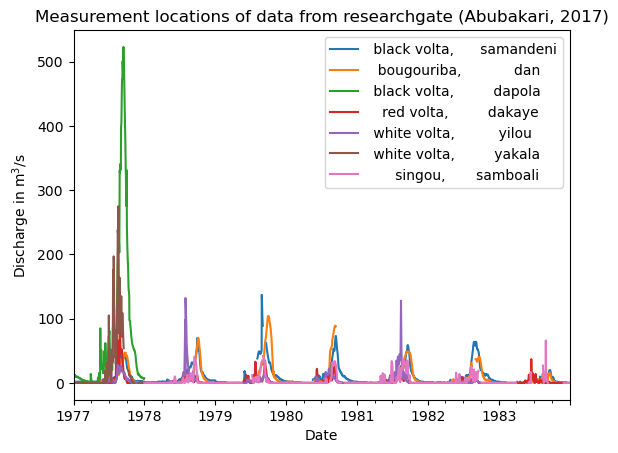

In [11]:
fig, ax = plt.subplots()
for index_wanted_station in df_stations_data[df_stations_data.Country_code == "BF"].lst_id:
    lst_df_q[index_wanted_station].rename(columns = {"Value":
                                                     df_stations_data.loc[index_wanted_station,'River'].lower() +','+ \
                                                     df_stations_data.loc[index_wanted_station,'Station_name'].lower()})\
                                  .plot(ax=ax)
ax.get_xticks()
ax.legend()
ax.set_ylabel("Discharge in m$^3$/s")
ax.set_xlabel("Date")
ax.set_title("Measurement locations of data from researchgate (Abubakari, 2017)");

**These 30 stations are more than provided by the client**<br>
This can be spatially previewed bellow:

In [12]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))

In [13]:
geometry = gpd.points_from_xy(df_stations_data.Lon, df_stations_data.Lat, crs="EPSG:4326")
gdf_stations = gpd.GeoDataFrame(data=df_stations_data, geometry=geometry)

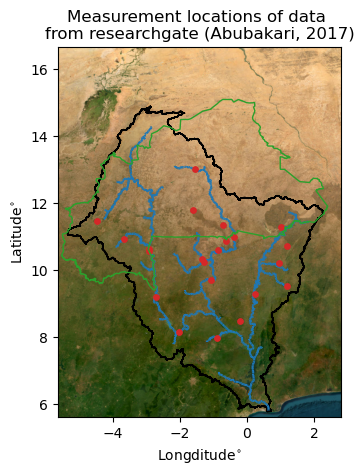

In [14]:
# quick way to get the bounds 
fig, ax = plt.subplots()

#adding features
volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')
main_rivers.plot(ax=ax, color="C0",zorder=1)
country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)

# get the bounds to add background
bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

# add stations
gdf_stations.plot(ax=ax,color="C3",markersize=15,zorder=5)
with rasterio.open(get_background_map("stations", bounds_stations)) as r:
    rioshow(r, ax=ax)

# set appearance
ax.set_title("Measurement locations of data \nfrom researchgate (Abubakari, 2017)")
ax.set_xlabel("Longditude$^{\circ}$");
ax.set_ylabel("Latitude$^{\circ}$");



In [15]:
output = False
if output:
    gdf_stations.to_file(f"{home_path}\\Combining data\\discharge_data_reasearch_gate.geojson")